<a href="https://colab.research.google.com/github/shinnew9/Apziva_practice_code/blob/main/Project2-TermDepositMarketing/3rdNote.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## About the project:
approach with a 2 layered ml system
1. 1st layer: focus on designing a ml model, which of the potential customers we should make calls to (haven't make any calls yet, can't use any call-related feature ex, duration, campaign, maonth of the call, etc)
- focus on reducing the # of calls w/o loosing a lot of subscribers, which means we want to focus on recall for class 0, capture as many

* They don't directly work each other, but overally impacts to each other.*


2. 2nd layer: we should design another ml model, which is predict which of the customers we should keep calling to (since calls have been made, I can use call-related data, actually predict which of the customers we should keep calling to make calls to)
- focus on precision on class 1, focus on current subscribers, how to prioritize those customers, identify those customers
- it will use the output of the 1st model(<-- which of the class should be made to, we can focus on which of the potential customers we should keep reaching out)
-


3. 3rd layer: who are the customers, the subscribers. To understand customer segmentation, we'll use unsupervised model.

3rd part.
- train unsupervised model, to understand who those customers are,
- filtered the non-subscribers
- goal is to segment the subscribers

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

# EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Models
import random
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report, confusion_matrix


from collections import Counter

In [ ]:
# Read dataset
df = pd.read_csv('/content/drive/MyDrive/Apziva/2ndProject/term-deposit-marketing-2020.csv')
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,53,technician,married,tertiary,no,395,no,no,cellular,3,jun,107,1,no
39996,30,management,single,tertiary,no,3340,no,no,cellular,3,jun,238,3,yes
39997,54,admin,divorced,secondary,no,200,no,no,cellular,3,jun,170,1,yes
39998,34,management,married,tertiary,no,1047,no,no,cellular,3,jun,342,1,no


In [ ]:
df[df['y']=='no'].count()   # 37104

,0
age,37104
job,37104
marital,37104
education,37104
default,37104
balance,37104
housing,37104
loan,37104
contact,37104
day,37104


In [ ]:
df[df['y']=='yes'].count()   # 2896

,0
age,2896
job,2896
marital,2896
education,2896
default,2896
balance,2896
housing,2896
loan,2896
contact,2896
day,2896


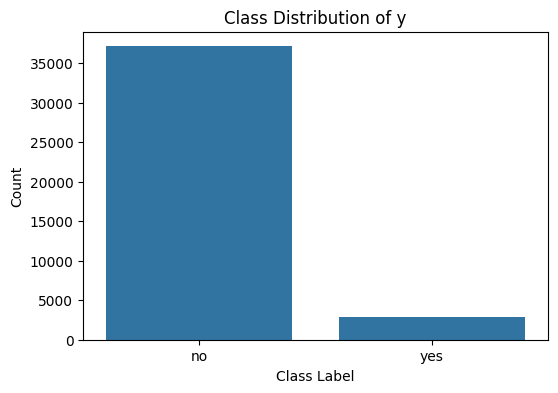

In [ ]:
class_counts = df['y'].value_counts()

# Plot the class distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Class Distribution of y')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.show()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40000 non-null  int64 
 1   job        40000 non-null  object
 2   marital    40000 non-null  object
 3   education  40000 non-null  object
 4   default    40000 non-null  object
 5   balance    40000 non-null  int64 
 6   housing    40000 non-null  object
 7   loan       40000 non-null  object
 8   contact    40000 non-null  object
 9   day        40000 non-null  int64 
 10  month      40000 non-null  object
 11  duration   40000 non-null  int64 
 12  campaign   40000 non-null  int64 
 13  y          40000 non-null  object
dtypes: int64(5), object(9)
memory usage: 4.3+ MB


## Models - 3 layers

In [ ]:
seed = random.randint(1000, 9999)
print(seed)  # 3373, 3068, 9263, 1155

1155


In [ ]:
# Step 1: Feature Selection & Encoding (Exclude call-related features and encode categorical features)
X = df.drop(columns=['duration', 'campaign', 'day', 'month', 'y'])
y = df['y'].apply(lambda x: 1 if x == 'yes' else 0)

# Identify categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns

# Encode categorical features
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le  # Store the encoders for later use if needed

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y)

### 1st Layer:

In [ ]:
# Step 3: Model Training (Random Forest Classifier)
model_1 = RandomForestClassifier(class_weight='balanced', random_state=seed)
model_1.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=6903)

1. SMOTE (Synthetic Minority Over-sampling Technique):
- Purpose: SMOTE is used to handle class imbalance by oversampling the minority class.
- How it works: Instead of duplicating the minority class samples, SMOTE creates synthetic examples. It does this by selecting a sample from the minority class, finding its k-nearest neighbors, and generating new synthetic samples that are interpolations between the original sample and one of its neighbors.
- Why use it: This method helps reduce the problem of overfitting that may occur if the minority class is simply oversampled by replication.

In [ ]:
# Apply SMOTE to balance the classes
sm = SMOTE(sampling_strategy = 'minority', random_state=seed)
undersample = RandomUnderSampler(sampling_strategy='majority', random_state=42)

X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print(f"Original dataset shape: {Counter(y_train)}")
print(f"Resampled dataset shape: {Counter(y_train_res)}")

# Step 3: Model Training (Random Forest Classifier)
model_1 = RandomForestClassifier(class_weight='balanced', random_state=42)
model_1.fit(X_train_res, y_train_res)

# Use the first model to filter data for the second model
predicted_calls = model_1.predict(X) == 0  # Potential subscribers identified by the 1st model

# Encode categorical features in X_layer2 BEFORE filtering
X_layer2 = df.drop(columns=['y'])
y_layer2 = df['y'].apply(lambda x: 1 if x == 'yes' else 0)
for col in categorical_cols:
    X_layer2[col] = label_encoders[col].transform(X_layer2[col])

X_layer2_filtered = X_layer2[predicted_calls]
y_layer2_filtered = y_layer2[predicted_calls]

# Handle 'month' encoding if necessary
if 'month' in X_layer2_filtered.columns:
    le_month = LabelEncoder()
    X_layer2_filtered['month'] = le_month.fit_transform(X_layer2_filtered['month'])

# Step 4: Train-test split for the second layer
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_layer2_filtered, y_layer2_filtered, test_size=0.3, random_state=42, stratify=y_layer2_filtered)

# Apply SMOTE to balance the classes for the second model
X_train2_res, y_train2_res = sm.fit_resample(X_train2, y_train2)

print(f"Original dataset shape for Layer 2: {Counter(y_train2)}")
print(f"Resampled dataset shape for Layer 2: {Counter(y_train2_res)}")

# Step 5: Model Training for the second layer (focus on precision for class 1)
model_2 = RandomForestClassifier(class_weight='balanced', random_state=42)
model_2.fit(X_train2_res, y_train2_res)

# Step 6: Prediction and Evaluation
y_pred2 = model_2.predict(X_test2)
print(classification_report(y_test2, y_pred2, target_names=['No', 'Yes']))

Original dataset shape: Counter({0: 25973, 1: 2027})
Resampled dataset shape: Counter({0: 25973, 1: 25973})


<ipython-input-26-0e3986b97e4e>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_layer2_filtered['month'] = le_month.fit_transform(X_layer2_filtered['month'])


Original dataset shape for Layer 2: Counter({0: 24678, 1: 505})
Resampled dataset shape for Layer 2: Counter({0: 24678, 1: 24678})
              precision    recall  f1-score   support

          No       0.98      0.98      0.98     10577
         Yes       0.19      0.26      0.22       217

    accuracy                           0.96     10794
   macro avg       0.59      0.62      0.60     10794
weighted avg       0.97      0.96      0.97     10794



In [ ]:
# SMOTEENN

# Step 1: Apply SMOTEENN to balance the classes
smoteenn = SMOTEENN(random_state=seed)

# Apply SMOTEENN on the first layer
X_train_res, y_train_res = smoteenn.fit_resample(X_train, y_train)

print(f"Original dataset shape: {Counter(y_train)}")
print(f"Resampled dataset shape: {Counter(y_train_res)}")

# Step 2: Model Training (Random Forest Classifier)
model_1 = RandomForestClassifier(class_weight='balanced', random_state=seed)
model_1.fit(X_train_res, y_train_res)

# Use the first model to filter data for the second model
predicted_calls = model_1.predict(X) == 0  # Potential subscribers identified by the 1st model

# Encode categorical features in X_layer2 BEFORE filtering
X_layer2 = df.drop(columns=['y'])
y_layer2 = df['y'].apply(lambda x: 1 if x == 'yes' else 0)
for col in categorical_cols:
    X_layer2[col] = label_encoders[col].transform(X_layer2[col])

X_layer2_filtered = X_layer2[predicted_calls]
y_layer2_filtered = y_layer2[predicted_calls]

# Handle 'month' encoding if necessary
if 'month' in X_layer2_filtered.columns:
    le_month = LabelEncoder()
    X_layer2_filtered['month'] = le_month.fit_transform(X_layer2_filtered['month'])

# Step 3: Train-test split for the second layer
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_layer2_filtered, y_layer2_filtered, test_size=0.3, random_state=seed, stratify=y_layer2_filtered)

# Apply SMOTEENN to balance the classes for the second model
X_train2_res, y_train2_res = smoteenn.fit_resample(X_train2, y_train2)

print(f"Original dataset shape for Layer 2: {Counter(y_train2)}")
print(f"Resampled dataset shape for Layer 2: {Counter(y_train2_res)}")

# Step 4: Model Training for the second layer (focus on precision for class 1)
model_2 = RandomForestClassifier(class_weight='balanced', random_state=seed)
model_2.fit(X_train2_res, y_train2_res)

# Step 5: Prediction and Evaluation
y_pred2 = model_2.predict(X_test2)
print(classification_report(y_test2, y_pred2, target_names=['No', 'Yes']))


# Try few more models - PyCaret (Compare models functionality), OpTuna for hyperparameter optimization
# Please apply the random seed as I print out


Original dataset shape: Counter({0: 25973, 1: 2027})
Resampled dataset shape: Counter({1: 19941, 0: 14878})


<ipython-input-30-fa6cbe536730>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_layer2_filtered['month'] = le_month.fit_transform(X_layer2_filtered['month'])


Original dataset shape for Layer 2: Counter({0: 22490, 1: 666})
Resampled dataset shape for Layer 2: Counter({1: 20668, 0: 18029})
              precision    recall  f1-score   support

          No       0.99      0.94      0.96      9639
         Yes       0.24      0.60      0.34       285

    accuracy                           0.93      9924
   macro avg       0.61      0.77      0.65      9924
weighted avg       0.97      0.93      0.95      9924



In [ ]:
# SMOTE

# Step 1: Apply SMOTE first to balance the classes
sm = SMOTE(sampling_strategy='minority', random_state=42)

# Apply SMOTE on the first layer
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Now apply Tomek Links to further clean the boundary by removing Tomek links
tomek = TomekLinks(sampling_strategy='majority')
X_train_res, y_train_res = tomek.fit_resample(X_train_res, y_train_res)

print(f"Original dataset shape: {Counter(y_train)}")
print(f"Resampled dataset shape after Tomek Links: {Counter(y_train_res)}")

# Step 2: Model Training (Random Forest Classifier)
model_1 = RandomForestClassifier(class_weight='balanced', random_state=42)
model_1.fit(X_train_res, y_train_res)

# Use the first model to filter data for the second model
predicted_calls = model_1.predict(X) == 0  # Potential subscribers identified by the 1st model

# Encode categorical features in X_layer2 BEFORE filtering
X_layer2 = df.drop(columns=['y'])
y_layer2 = df['y'].apply(lambda x: 1 if x == 'yes' else 0)
for col in categorical_cols:
    X_layer2[col] = label_encoders[col].transform(X_layer2[col])

X_layer2_filtered = X_layer2[predicted_calls]
y_layer2_filtered = y_layer2[predicted_calls]

# Handle 'month' encoding if necessary
if 'month' in X_layer2_filtered.columns:
    le_month = LabelEncoder()
    X_layer2_filtered['month'] = le_month.fit_transform(X_layer2_filtered['month'])

# Step 3: Train-test split for the second layer
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_layer2_filtered, y_layer2_filtered, test_size=0.3, random_state=42, stratify=y_layer2_filtered)

# Apply SMOTE to balance the classes for the second model
X_train2_res, y_train2_res = sm.fit_resample(X_train2, y_train2)

# Now apply Tomek Links to the second layer to clean the class boundaries
X_train2_res, y_train2_res = tomek.fit_resample(X_train2_res, y_train2_res)

print(f"Original dataset shape for Layer 2: {Counter(y_train2)}")
print(f"Resampled dataset shape for Layer 2 after Tomek Links: {Counter(y_train2_res)}")

# Step 4: Model Training for the second layer (focus on precision for class 1)
model_2 = RandomForestClassifier(class_weight='balanced', random_state=42)
model_2.fit(X_train2_res, y_train2_res)

# Step 5: Prediction and Evaluation
y_pred2 = model_2.predict(X_test2)
print(classification_report(y_test2, y_pred2, target_names=['No', 'Yes']))

Original dataset shape: Counter({0: 25973, 1: 2027})
Resampled dataset shape after Tomek Links: Counter({1: 25973, 0: 25060})


<ipython-input-28-2b6530c24d75>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_layer2_filtered['month'] = le_month.fit_transform(X_layer2_filtered['month'])


Original dataset shape for Layer 2: Counter({0: 24476, 1: 504})
Resampled dataset shape for Layer 2 after Tomek Links: Counter({1: 24476, 0: 24216})
              precision    recall  f1-score   support

          No       0.98      0.97      0.98     10490
         Yes       0.16      0.26      0.20       216

    accuracy                           0.96     10706
   macro avg       0.57      0.62      0.59     10706
weighted avg       0.97      0.96      0.96     10706



## Recommendations:
1. Try to apply Random Seed, (Not always using 42) <br>
2. Different strategies:  <br>
1) RandomUnderSampler(<--Safest, Since it is not generating the new data) <br>
2) SMOTE, when it is highly imbalanced, it may problematic (97% subscribed, 3 are not, which is very imbalancedd, if you are increasing the minority, it may cause problems)

  Try others instead: <br>
    2-2-1) SMOTEENN <br>
    2-2-2) SMOTE-TOMEK: Search, Read about it and understand "Tomek links", Take some time on studying the new concept <br>
<br>
Get used to popular method: <br>
"PyCaret": use some functions (compare modelds, which would be able to compare models)
Then choose 3 models listed in here, Use classificiation report,
1. For the 1st layer, focus on recall for class 1, subscribers (which is 27% above)
2. For the layer 2, train a different model

Recommendations:
1. Think concrete about my career goal: <br>
- Confidence vs Working abroad <br>

2. Getting a job in the States is extremely challenging, not easy, BUT! It's possible!
- Apply for a visa Sponsorship, I should have be professional.  
- Realistically spking, "I'm talented" He's expecting a lot from me. Try to be more confident.
- If I'm goot at, maybe some big tech (SAMSUNG) can call me.
- Increase to get a job for a better paying job.  